In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline

# feature engineering, selection + preprocessing tools
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from feature_engine.encoding import OrdinalEncoder
from feature_engine.outliers import OutlierTrimmer
from datetime import datetime
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

# models
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier

# metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import confusion_matrix

In [2]:
plt.style.use('default')
plt.rcdefaults()
plt.style.use('default')

In [3]:
# function to check missing & duplicated values
def check_data(df):
    print('-' *50)
    
    missing_data = df.isnull().sum().sum()
    
    print(f'There are {missing_data} missing values in the dataset.')
    print(f'There are {df.duplicated().sum().sum()} duplicated values in the dataset.')
    print('-' *50)
    
    if missing_data > 0:
        print('Missing values:')
        print(df.isnull().sum().sort_values(ascending=False))
        print('-' *50)

In [4]:
df_cust = pd.read_csv('dataset/marketing_campaign.csv', sep='\t')
df_cust.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [5]:
check_data(df_cust)

--------------------------------------------------
There are 24 missing values in the dataset.
There are 0 duplicated values in the dataset.
--------------------------------------------------
Missing values:
Income                 24
ID                      0
NumDealsPurchases       0
Z_Revenue               0
Z_CostContact           0
Complain                0
AcceptedCmp2            0
AcceptedCmp1            0
AcceptedCmp5            0
AcceptedCmp4            0
AcceptedCmp3            0
NumWebVisitsMonth       0
NumStorePurchases       0
NumCatalogPurchases     0
NumWebPurchases         0
MntGoldProds            0
Year_Birth              0
MntSweetProducts        0
MntFishProducts         0
MntMeatProducts         0
MntFruits               0
MntWines                0
Recency                 0
Dt_Customer             0
Teenhome                0
Kidhome                 0
Marital_Status          0
Education               0
Response                0
dtype: int64
-------------------------

In [6]:
len(df_cust)

2240

In [7]:
# Drop the missing values (Complete Case Analysis)
df_cust.dropna(inplace=True)
check_data(df_cust)

--------------------------------------------------
There are 0 missing values in the dataset.
There are 0 duplicated values in the dataset.
--------------------------------------------------


In [8]:
df_cust.columns

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response'],
      dtype='object')

In [9]:
df_cust.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2216 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2216 non-null   int64  
 1   Year_Birth           2216 non-null   int64  
 2   Education            2216 non-null   object 
 3   Marital_Status       2216 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2216 non-null   int64  
 6   Teenhome             2216 non-null   int64  
 7   Dt_Customer          2216 non-null   object 
 8   Recency              2216 non-null   int64  
 9   MntWines             2216 non-null   int64  
 10  MntFruits            2216 non-null   int64  
 11  MntMeatProducts      2216 non-null   int64  
 12  MntFishProducts      2216 non-null   int64  
 13  MntSweetProducts     2216 non-null   int64  
 14  MntGoldProds         2216 non-null   int64  
 15  NumDealsPurchases    2216 non-null   int64 

Feature Extraction & Engineering

In [10]:
cat_cols = [var for var in df_cust.columns if df_cust[var].dtype == 'O']
# print value coutns for each categorical column
for col in cat_cols:
    print(df_cust[col].value_counts())
    print('-'*50)

Education
Graduation    1116
PhD            481
Master         365
2n Cycle       200
Basic           54
Name: count, dtype: int64
--------------------------------------------------
Marital_Status
Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: count, dtype: int64
--------------------------------------------------
Dt_Customer
31-08-2012    12
12-09-2012    11
14-02-2013    11
12-05-2014    11
20-08-2013    10
              ..
05-08-2012     1
18-11-2012     1
09-05-2014     1
26-06-2013     1
09-01-2014     1
Name: count, Length: 662, dtype: int64
--------------------------------------------------


Adding `Age` & `EnrollmentDate` columns

In [11]:
df_cust['Age'] = datetime.now().year - df_cust['Year_Birth']
df_cust['EnrollmentDate'] = pd.to_datetime(df_cust['Dt_Customer'], format='%d-%m-%Y').apply(lambda x: x.year)

# removing unnecessary columns
df_cust = df_cust.drop(['Year_Birth', 'Dt_Customer', 'ID'], axis=1)

Fixing `Education` & `Marital_Status` format

In [12]:
# based on google, 2n cycle is master degree
df_cust['Education'] = df_cust['Education'].replace({'2n Cycle': 'Master'})

# fixing Marital_Status format
df_cust['Marital_Status'] = df_cust['Marital_Status'].replace({
    'Married': 'In a Relationship',
    'Together': 'In a Relationship',
    'Divorced': 'Single',
    'Widow': 'Single',
    'Alone': 'Single',
    'YOLO': 'Single',
    'Absurd': 'Single',
})

people_per_household = df_cust['Marital_Status'].replace({
    'In a Relationship': 2,
    'Single': 1
})

Adding `Family_Size` column

In [13]:
df_cust['Family_Size'] = df_cust['Kidhome'] + df_cust['Teenhome'] + people_per_household

In [14]:
cat_cols = [var for var in df_cust.columns if df_cust[var].dtype == 'O']
# print value coutns for each categorical column
for col in cat_cols:
    print(df_cust[col].value_counts())
    print('-'*50)

Education
Graduation    1116
Master         565
PhD            481
Basic           54
Name: count, dtype: int64
--------------------------------------------------
Marital_Status
In a Relationship    1430
Single                786
Name: count, dtype: int64
--------------------------------------------------


Adding `Num_Total_Purchases`, `Num_Accepted_Cmp` & `Total_Amount_Spent` columns

In [15]:
purchases = ['NumCatalogPurchases', 'NumStorePurchases', 'NumWebPurchases']
df_cust['Num_Total_Purchases'] = df_cust[purchases].sum(axis=1)

promotions = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response']
df_cust['Num_Accepted_Cmp'] = df_cust[promotions].sum(axis=1)

mnt_products = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
df_cust['Total_Amount_Spent'] = df_cust[mnt_products].sum(axis=1)

In [16]:
df_cust.sample(2, random_state=42)

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,Complain,Z_CostContact,Z_Revenue,Response,Age,EnrollmentDate,Family_Size,Num_Total_Purchases,Num_Accepted_Cmp,Total_Amount_Spent
961,PhD,Single,52597.0,0,1,69,492,0,37,7,...,0,3,11,0,62,2014,2,17,0,578
229,PhD,In a Relationship,34320.0,1,0,66,4,1,9,3,...,0,3,11,0,38,2014,3,3,0,17


Variable Encoding

In [17]:
cat_cols = [var for var in df_cust.columns if df_cust[var].dtype == 'O']
cat_cols

['Education', 'Marital_Status']

In [18]:
label_encoder = OrdinalEncoder(
    encoding_method='arbitrary',
    variables=cat_cols
)

label_encoder.fit(df_cust)

# Transform the data
df_cust = label_encoder.transform(df_cust)

Handling Outliers

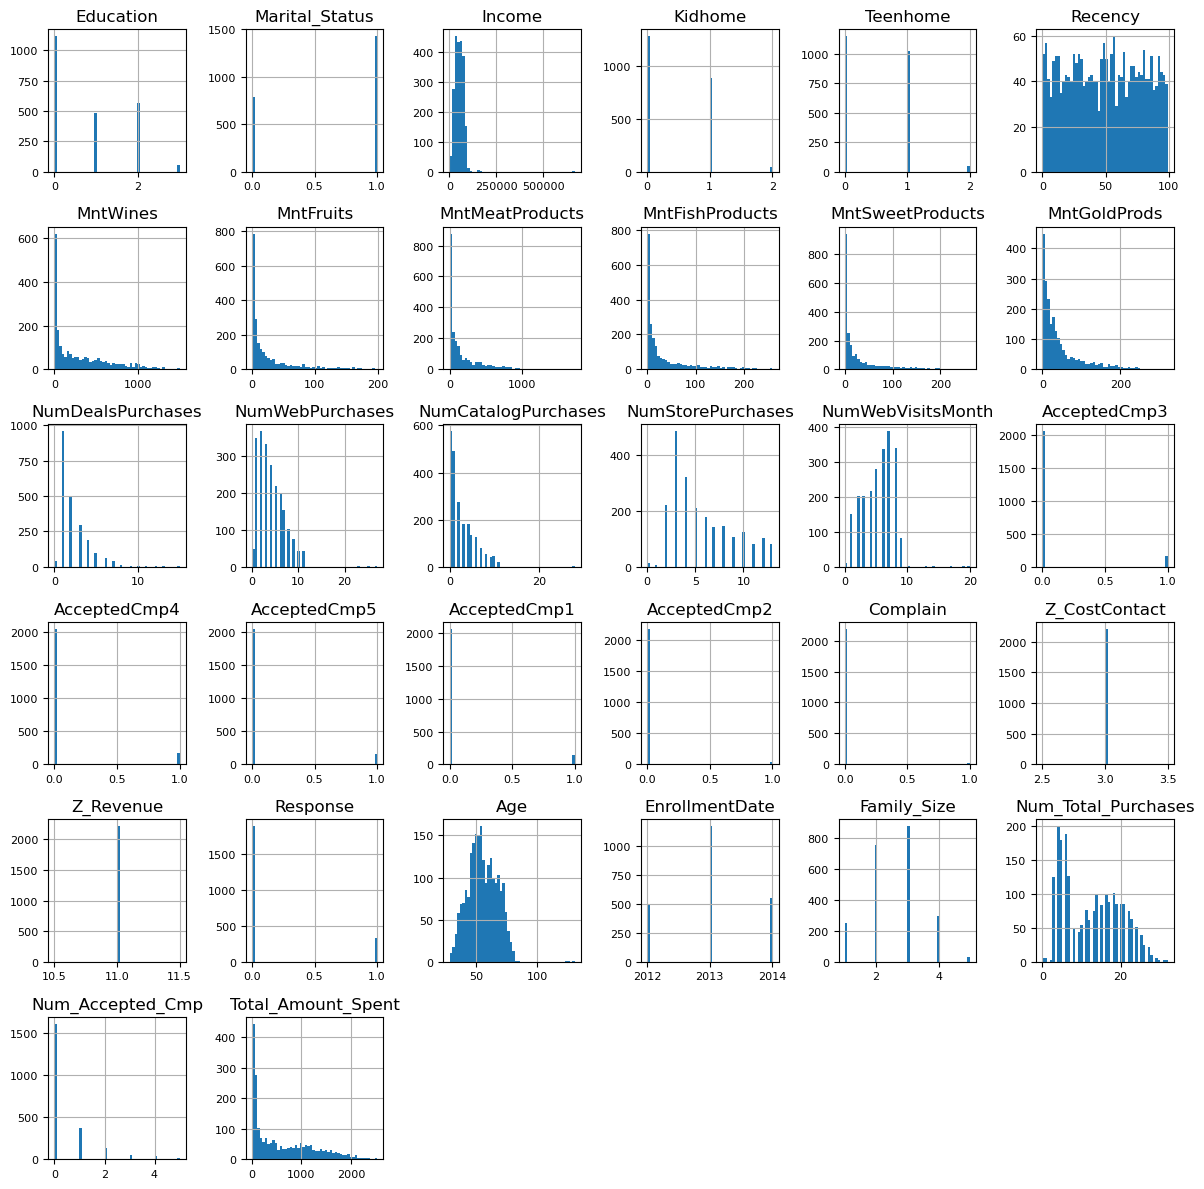

In [19]:
num_cols = [var for var in df_cust.columns if df_cust[var].dtype != 'O']

df_cust[num_cols].hist(figsize=(12, 12), bins=50, xlabelsize=8, ylabelsize=8)
plt.tight_layout()
plt.show()

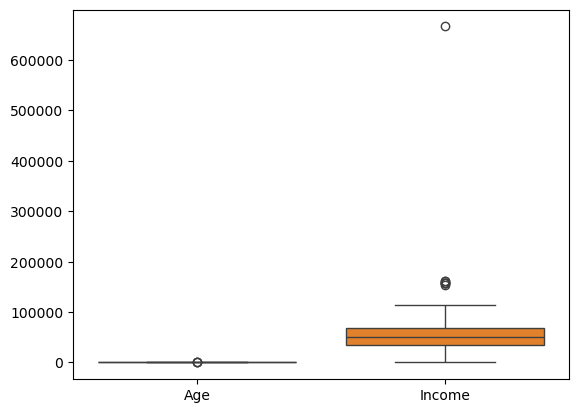

In [20]:
sns.boxplot(df_cust[['Age', 'Income']])
plt.show()

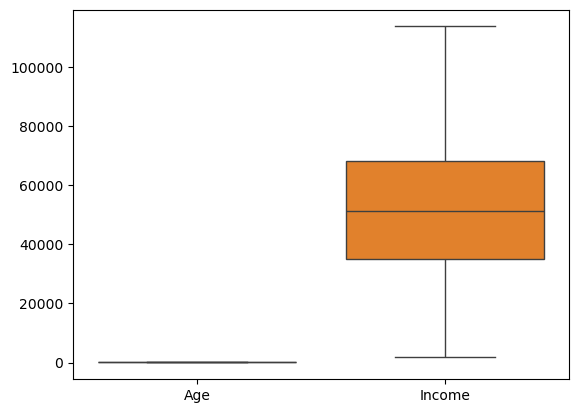

In [21]:
# removing ourliers on specific columns
remove_outlier = OutlierTrimmer(
    capping_method='iqr',
    tail='right',
    variables=['Age', 'Income']
)

df_cust = remove_outlier.fit_transform(df_cust)
sns.boxplot(df_cust[['Age', 'Income']])
plt.show()

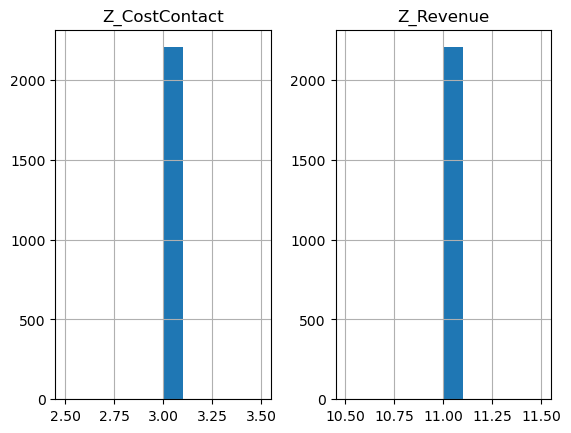

In [22]:
df_cust[['Z_CostContact', 'Z_Revenue']].hist()
plt.show()

We will need to drop `Z_CostContact` & `Z_Revenue` columns because it doesnt give us any informations

In [23]:
df_cust.drop(['Z_CostContact', 'Z_Revenue'], axis=1, inplace=True)

Feature Scaling:
- Apply Normalization on normalized distributed data
- Apply Standardization on skewed data

In [24]:
min_max_cols = ['Income', 'Recency', 'Age', 'Family_Size',
                'EnrollmentDate']
ss_scaler_cols = ['Kidhome', 'Teenhome', 'MntWines', 'MntFruits', 'MntMeatProducts',
                  'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases',
                  'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
                  'Num_Total_Purchases', 'Num_Accepted_Cmp', 'Total_Amount_Spent']

# copying original df to new df for scaling
df_cust_scaled = df_cust.copy()

# min max scaling
min_max_scaler = MinMaxScaler()
df_cust_scaled[min_max_cols] = min_max_scaler.fit_transform(df_cust[min_max_cols])

# standard scaling
ss_scaler = StandardScaler()
df_cust_scaled[ss_scaler_cols] = ss_scaler.fit_transform(df_cust[ss_scaler_cols])

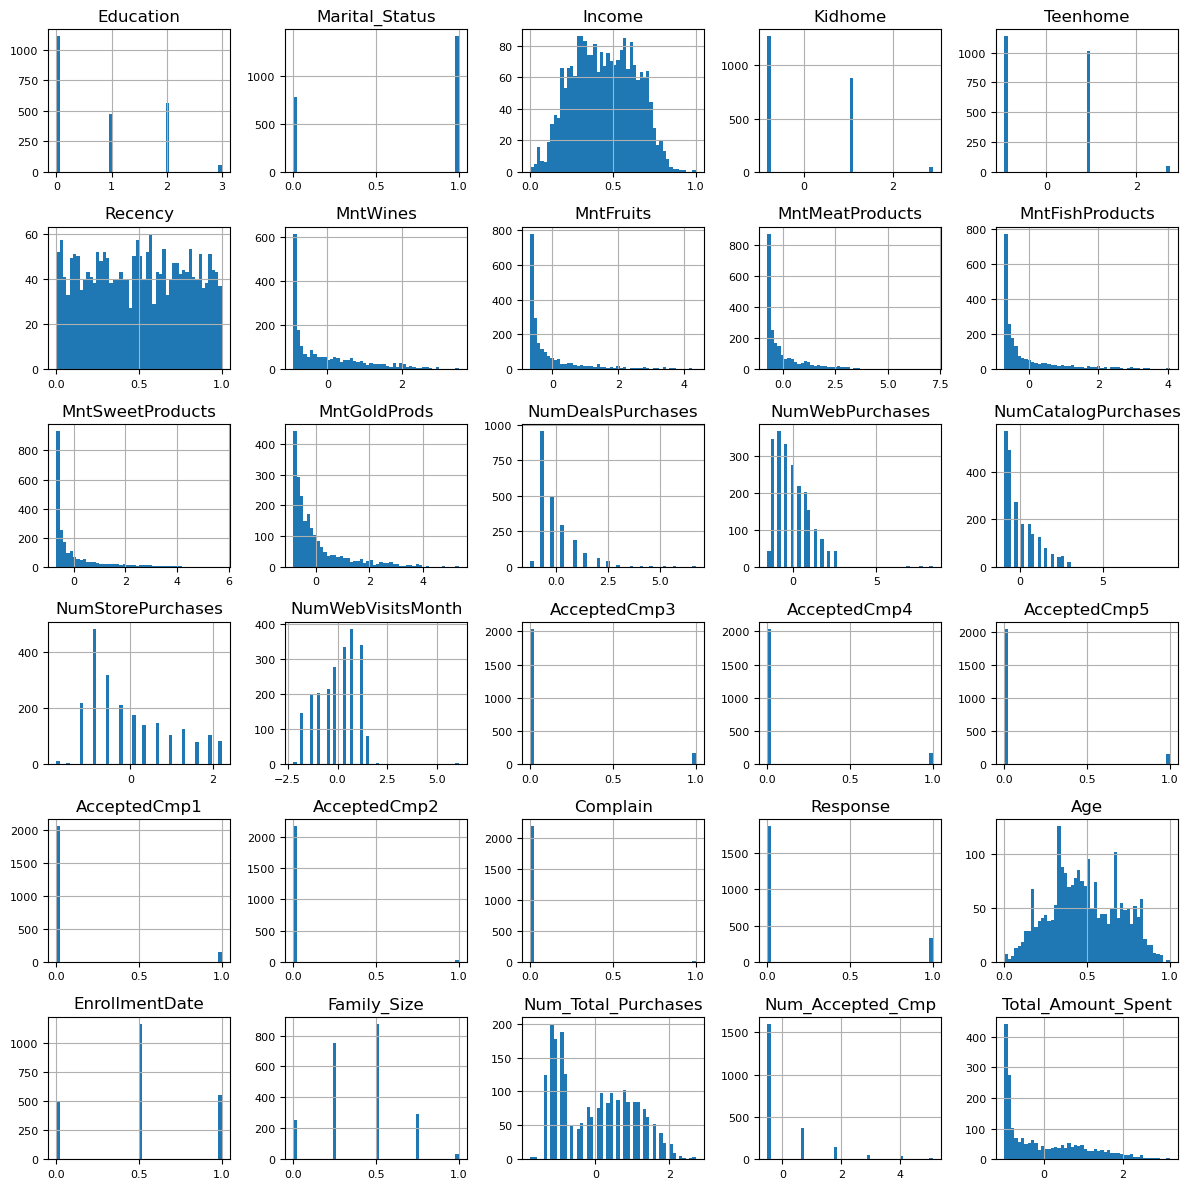

In [25]:
num_cols = [var for var in df_cust_scaled.columns if df_cust_scaled[var].dtype != 'O']

df_cust_scaled[num_cols].hist(figsize=(12, 12), bins=50, xlabelsize=8, ylabelsize=8)
plt.tight_layout()
plt.show()

Applying PCA for Dimensionality Reduction

In [26]:
df_cust.columns, len(df_cust.columns)

(Index(['Education', 'Marital_Status', 'Income', 'Kidhome', 'Teenhome',
        'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts',
        'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
        'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
        'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3',
        'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2',
        'Complain', 'Response', 'Age', 'EnrollmentDate', 'Family_Size',
        'Num_Total_Purchases', 'Num_Accepted_Cmp', 'Total_Amount_Spent'],
       dtype='object'),
 30)

In [27]:
# reduce dimentionality into 3 components
pca = PCA(n_components=3)
pca.fit(df_cust_scaled)

pca_df = pd.DataFrame(pca.transform(df_cust_scaled), columns=['PC1', 'PC2', 'PC3'])
pca_df.head()

,PC1,PC2,PC3
0,4.602137,-0.195359,0.475265
1,-2.922977,-0.406073,-0.424539
2,1.866104,-0.144668,-0.950161
3,-2.615311,-0.914040,-0.065611
4,-0.404520,0.308650,-0.404327


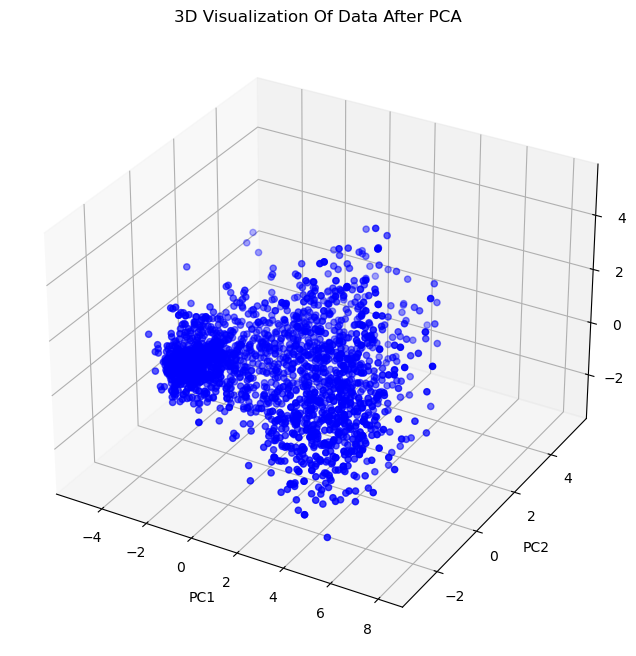

In [28]:
x, y, z = pca_df['PC1'], pca_df['PC2'], pca_df['PC3']

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x,y,z, c="blue", marker="o" )
ax.set_title("3D Visualization Of Data After PCA")
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

plt.show()

In [29]:
# 3D interactive scatter plot
fig = px.scatter_3d(
    pca_df,
    x='PC1',
    y='PC2',
    z='PC3',
    title='3D Visualization Of Data After PCA'
)

fig.update_layout(
    scene=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3'
    )
)

fig.show()


For Clustering, we'll be using: `KMeans Clustering`

KMeans Clustering

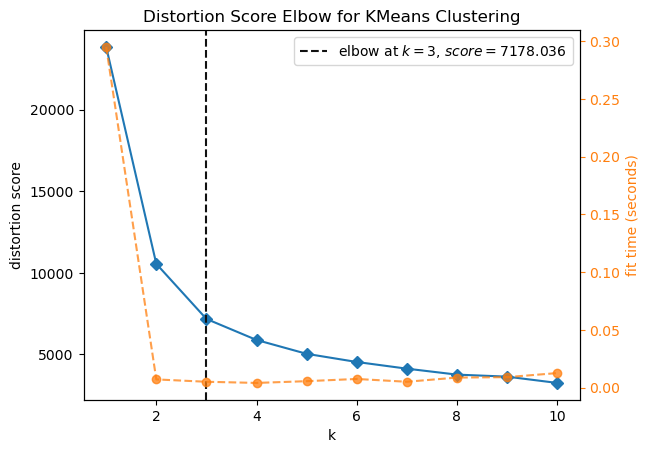

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [30]:
kmeans = KMeans()
visualizer = KElbowVisualizer(kmeans, k=(1,11))
visualizer.fit(pca_df)
visualizer.show()

From the plot above, the optimal cluster for KMeans is 3

In [31]:
kmeans = KMeans(n_clusters=3, random_state=0)

y_kmeans = kmeans.fit_predict(pca_df)

# add cluster to original dataframe
df_cust['Cluster_KMeans'] = y_kmeans

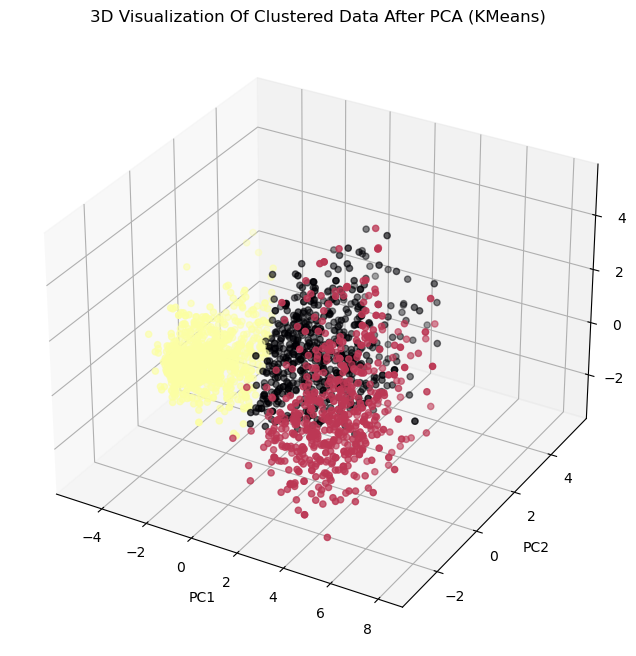

In [32]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x,y,z, c=y_kmeans, marker="o", cmap='inferno', )
ax.set_title("3D Visualization Of Clustered Data After PCA (KMeans)")
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

plt.show()

In [33]:
# 3D interactive scatter plot
fig = px.scatter_3d(
    pca_df,
    x='PC1',
    y='PC2',
    z='PC3',
    color=y_kmeans,
    title='3D Visualization Of Clustered Data After PCA (KMeans)',
)

fig.update_layout(
    scene=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3'
    )
)

fig.show()

Evaluating our Clusters (KMeans)

In [34]:
palette_kmeans = ['#679436', '#eb5e28', '#4361ee']

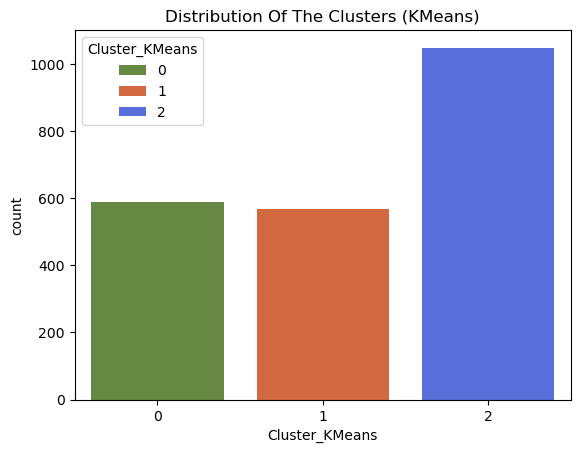

In [35]:
sns.countplot(x=df_cust["Cluster_KMeans"], hue=df_cust["Cluster_KMeans"], palette=palette_kmeans)
plt.title("Distribution Of The Clusters (KMeans)")
plt.show()

C:\Users\ardav\AppData\Local\Temp\ipykernel_24492\259574998.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




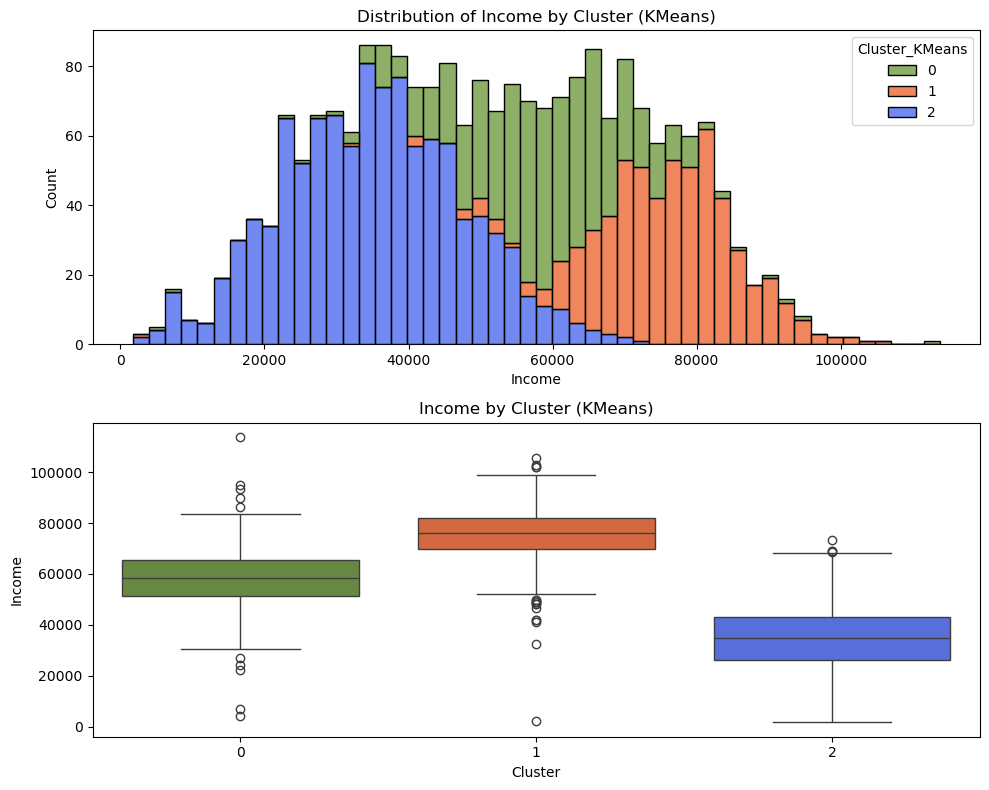

In [36]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

sns.histplot(data=df_cust, x='Income', hue='Cluster_KMeans', palette=palette_kmeans, bins=50, multiple='stack', ax=ax[0])
ax[0].set_title('Distribution of Income by Cluster (KMeans)')
ax[0].set_xlabel('Income')
ax[0].set_ylabel('Count')

sns.boxplot(data=df_cust, x='Cluster_KMeans', y='Income', palette=palette_kmeans, ax=ax[1])
ax[1].set_title('Income by Cluster (KMeans)')
ax[1].set_xlabel('Cluster')
ax[1].set_ylabel('Income')

plt.tight_layout()
plt.show()

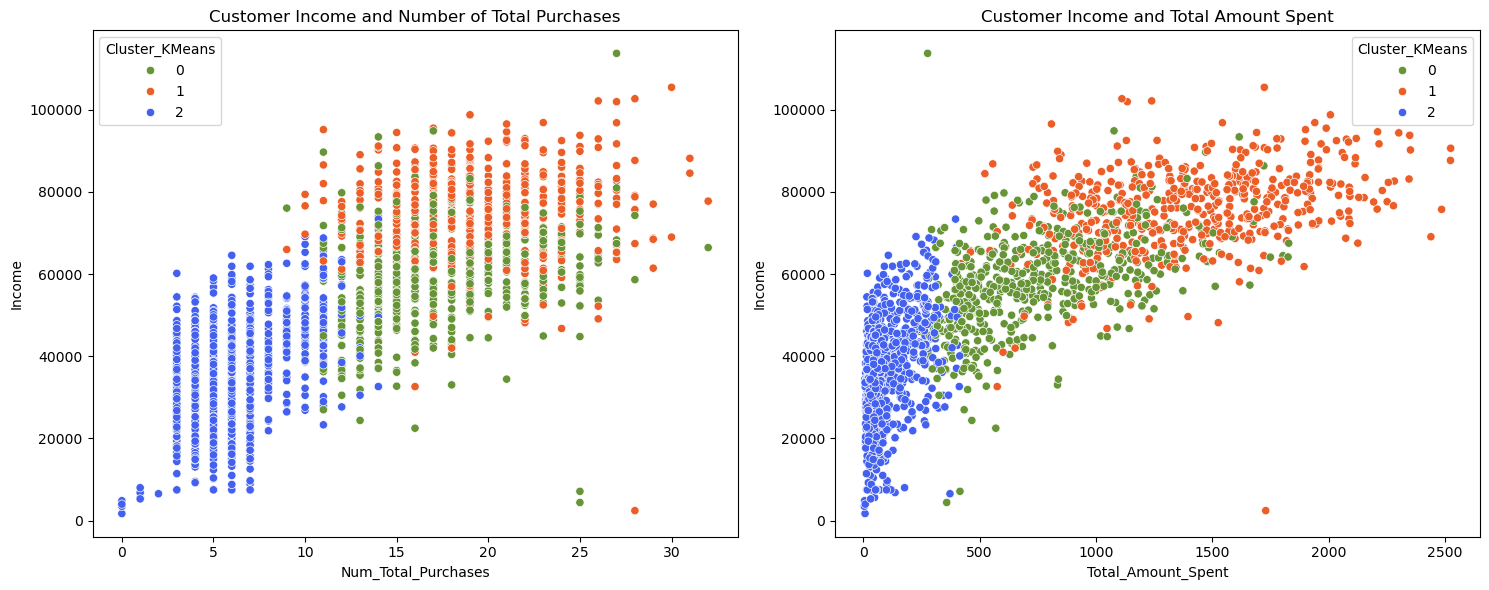

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Income vs Num_Total_Purchases
sns.scatterplot(x='Num_Total_Purchases', y='Income', data=df_cust, hue='Cluster_KMeans', palette=palette_kmeans, ax=axes[0])
axes[0].set_title('Customer Income and Number of Total Purchases')
axes[0].set_xlabel('Num_Total_Purchases')
axes[0].set_ylabel('Income')

# Income vs Total_Amount_Spent
sns.scatterplot(x='Total_Amount_Spent', y='Income', data=df_cust, hue='Cluster_KMeans', palette=palette_kmeans, ax=axes[1])
axes[1].set_title('Customer Income and Total Amount Spent')
axes[1].set_xlabel('Total_Amount_Spent')
axes[1].set_ylabel('Income')

plt.tight_layout()
plt.show()

C:\Users\ardav\AppData\Local\Temp\ipykernel_24492\4056634925.py:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




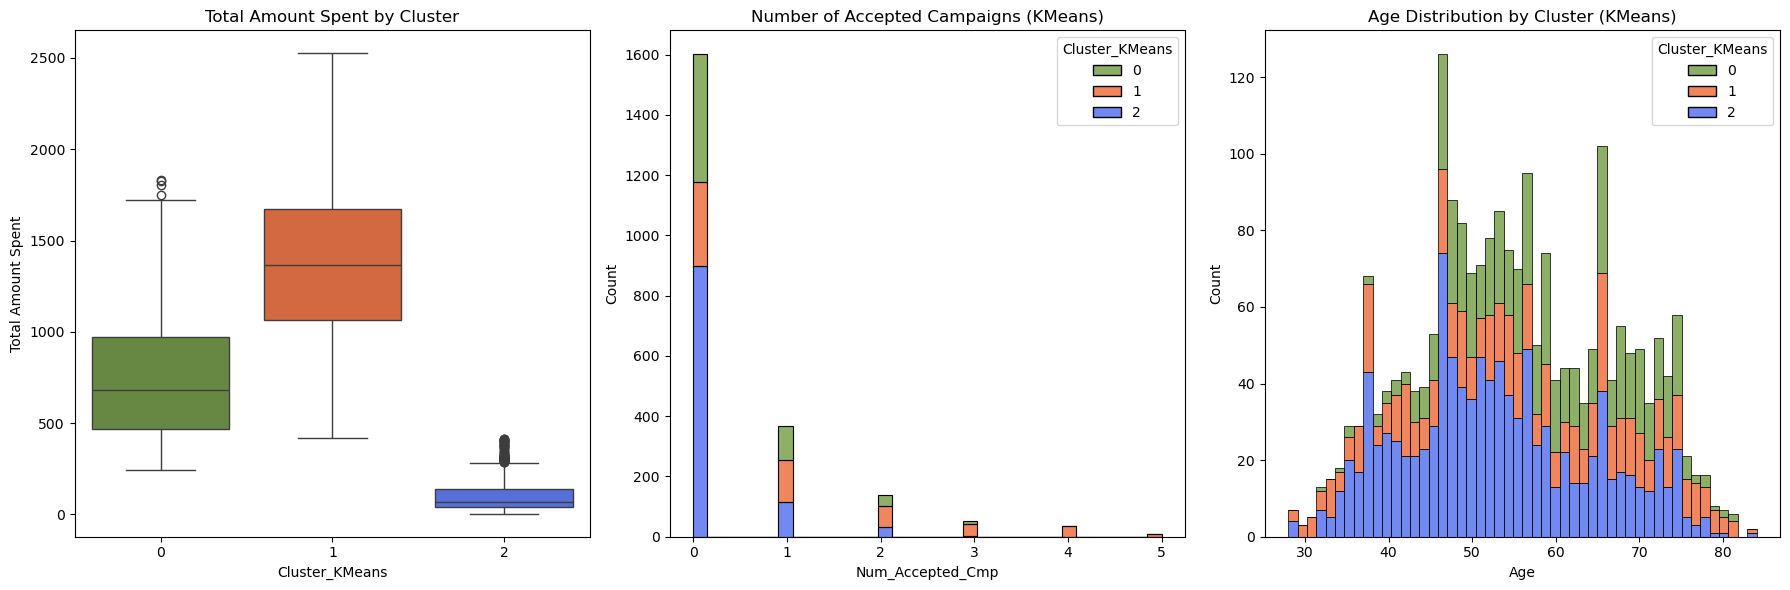

In [38]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# boxplot for Total Amount Spent by Cluster
sns.boxplot(data=df_cust, x='Cluster_KMeans', y='Total_Amount_Spent', palette=palette_kmeans, ax=ax[0])
ax[0].set_title('Total Amount Spent by Cluster')
ax[0].set_xlabel('Cluster_KMeans')
ax[0].set_ylabel('Total Amount Spent')

# histogram for Number of Accepted Campaigns
sns.histplot(data=df_cust, x="Num_Accepted_Cmp", hue="Cluster_KMeans", multiple="stack", palette=palette_kmeans, ax=ax[1])
ax[1].set_title('Number of Accepted Campaigns (KMeans)')
ax[1].set_xlabel('Num_Accepted_Cmp')
ax[1].set_ylabel('Count')

# histogram for Age Distribution by Cluster
sns.histplot(data=df_cust, x='Age', hue='Cluster_KMeans', palette=palette_kmeans, bins=50, multiple='stack', ax=ax[2])
ax[2].set_title('Age Distribution by Cluster (KMeans)')
ax[2].set_xlabel('Age')
ax[2].set_ylabel('Count')

plt.tight_layout()
plt.show()

In [39]:
df_cust.head()

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,AcceptedCmp2,Complain,Response,Age,EnrollmentDate,Family_Size,Num_Total_Purchases,Num_Accepted_Cmp,Total_Amount_Spent,Cluster_KMeans
0,0,0,58138.0,0,0,58,635,88,546,172,...,0,0,1,67,2012,1,22,1,1617,1
1,0,0,46344.0,1,1,38,11,1,6,2,...,0,0,0,70,2014,3,4,0,27,2
2,0,1,71613.0,0,0,26,426,49,127,111,...,0,0,0,59,2013,2,20,0,776,0
3,0,1,26646.0,1,0,26,11,4,20,10,...,0,0,0,40,2014,3,6,0,53,2
4,1,1,58293.0,1,0,94,173,43,118,46,...,0,0,0,43,2014,3,14,0,422,0


Insights Conclusion:
1. Cluster 0 (Green)
    - Income Distribution: Primarily between $40,000 and $70,000. The income is relatively well-distributed with a few outliers on both the higher and lower ends.
    - Spending Behavior: Moderate spender, with most spending between $500 and $1,000. There is a reasonable number of accepted campaigns, indicating moderate engagement with promotional offers.
    - Age Distribution: The age distribution peaks around 50 years, indicating that this cluster likely consists of middle-aged individuals.
2. Cluster 1 (Orange)
    - Income Distribution: High-income individuals with most having incomes above $70,000.
    - Spending Behavior: Highest spenders, with amounts ranging between $1,000 and $2,000. They show significant engagement in marketing campaigns, likely because they have higher disposable incomes.
    - Age Distribution: The age distribution is spread out, with a peak around 40-50 years, suggesting that this cluster contains relatively younger but financially successful individuals.
3. Cluster 2 (Blue)
    - Income Distribution: This cluster consists of low-income individuals, predominantly earning between $0 and $40,000.
    - Spending Behavior: These individuals spend the least, with the majority spending under $500.
    - Age Distribution: The age distribution shows a broad spread but with a significant portion of younger individuals, possibly under 40 years of age.

Train our classification model to predict the cluster

In [40]:
df_cust.head()

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,AcceptedCmp2,Complain,Response,Age,EnrollmentDate,Family_Size,Num_Total_Purchases,Num_Accepted_Cmp,Total_Amount_Spent,Cluster_KMeans
0,0,0,58138.0,0,0,58,635,88,546,172,...,0,0,1,67,2012,1,22,1,1617,1
1,0,0,46344.0,1,1,38,11,1,6,2,...,0,0,0,70,2014,3,4,0,27,2
2,0,1,71613.0,0,0,26,426,49,127,111,...,0,0,0,59,2013,2,20,0,776,0
3,0,1,26646.0,1,0,26,11,4,20,10,...,0,0,0,40,2014,3,6,0,53,2
4,1,1,58293.0,1,0,94,173,43,118,46,...,0,0,0,43,2014,3,14,0,422,0


In [41]:
# replcae 0: 'Graduation', 1: 'PHD', 2: 'Master', 3:'Basic' in column 'education'
df_cust['Education'] = df_cust['Education'].replace([0, 1, 2, 3], ['Graduation', 'PHD', 'Master', 'Basic'])

# replace 0: 'Single', 1: 'In a relationship' in column 'Marital_Status'
df_cust['Marital_Status'] = df_cust['Marital_Status'].replace([0, 1], ['Single', 'In a relationship'])

In [42]:
cat_cols

['Education', 'Marital_Status']

In [43]:
label_encoder.__dict__

{'variables': ['Education', 'Marital_Status'],
 'ignore_format': False,
 'missing_values': 'raise',
 'encoding_method': 'arbitrary',
 'unseen': 'ignore',
 'encoder_dict_': {'Education': {'Graduation': 0,
   'PhD': 1,
   'Master': 2,
   'Basic': 3},
  'Marital_Status': {'Single': 0, 'In a Relationship': 1}},
 'variables_': ['Education', 'Marital_Status'],
 'feature_names_in_': ['Education',
  'Marital_Status',
  'Income',
  'Kidhome',
  'Teenhome',
  'Recency',
  'MntWines',
  'MntFruits',
  'MntMeatProducts',
  'MntFishProducts',
  'MntSweetProducts',
  'MntGoldProds',
  'NumDealsPurchases',
  'NumWebPurchases',
  'NumCatalogPurchases',
  'NumStorePurchases',
  'NumWebVisitsMonth',
  'AcceptedCmp3',
  'AcceptedCmp4',
  'AcceptedCmp5',
  'AcceptedCmp1',
  'AcceptedCmp2',
  'Complain',
  'Z_CostContact',
  'Z_Revenue',
  'Response',
  'Age',
  'EnrollmentDate',
  'Family_Size',
  'Num_Total_Purchases',
  'Num_Accepted_Cmp',
  'Total_Amount_Spent'],
 'n_features_in_': 32}

In [44]:
X = df_cust.drop(['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Cluster_KMeans'], axis=1)
y = df_cust['Cluster_KMeans']

In [45]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size= 0.2,
    random_state=0
)

X_train.shape, X_test.shape

((1764, 25), (441, 25))

In [46]:
transformer = ColumnTransformer([
    ('mms_scaler', MinMaxScaler(), min_max_cols),
    ('ss_scaler', StandardScaler(), ss_scaler_cols)
])

pipeline = make_pipeline(transformer, GradientBoostingClassifier(random_state=42))

In [47]:
def model_train(model):
    model.fit(X_train, y_train)
    
    y_preds_test = model.predict(X_test)
    
    print('Test set performance')
    print()
    print(f"Accuracy: {accuracy_score(y_test, y_preds_test)}")
    print(f"Precision: {precision_score(y_test, y_preds_test, average='weighted')}")
    print(f"Recall: {recall_score(y_test, y_preds_test, average='weighted')}")
    print(f"F1 Score: {f1_score(y_test, y_preds_test, average='weighted')}")
    print('-'*50)

    # plot the confusion matrix for the test set only
    cm = confusion_matrix(y_test, y_preds_test)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.title(f'Confusion Matrix (Test Set): {model}')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

In [48]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('mms_scaler', MinMaxScaler(),
                                                  ['Income', 'Recency', 'Age',
                                                   'Family_Size',
                                                   'EnrollmentDate']),
                                                 ('ss_scaler', StandardScaler(),
                                                  ['Kidhome', 'Teenhome',
                                                   'MntWines', 'MntFruits',
                                                   'MntMeatProducts',
                                                   'MntFishProducts',
                                                   'MntSweetProducts',
                                                   'MntGoldProds',
                                                   'NumDealsPurchases',
                                                   'NumWebPurchases',
                                                   'NumCatalogPurchases',
                                                   'NumStorePurchases',
                                                   'NumWebVisitsMonth',
                                                   'Num_Total_Purchases',
                                                   'Num_Accepted_Cmp',
                                                   'Total_Amount_Spent'])])),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(random_state=42))])

Test set performance

Accuracy: 0.9795918367346939
Precision: 0.9795379970742568
Recall: 0.9795918367346939
F1 Score: 0.9795447134369716
--------------------------------------------------


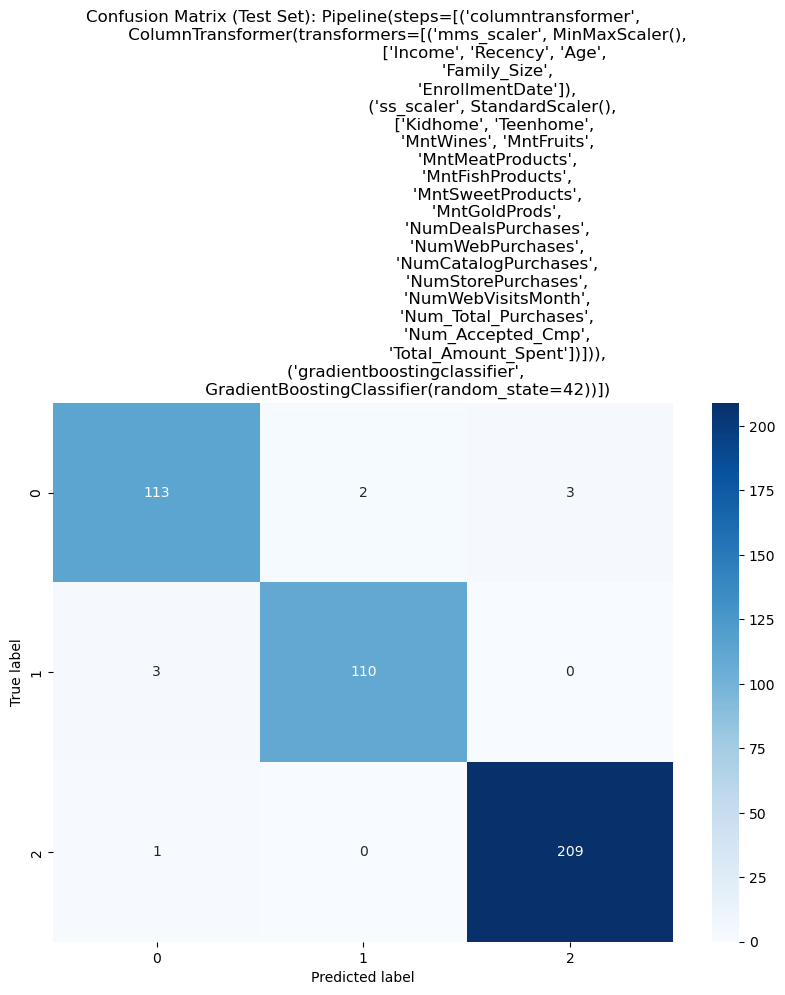

In [49]:
model_train(pipeline)

Save our model for deployment

In [50]:
import pickle as pkl

with open('.pkl/pipeline.pkl', 'wb') as f:
    pkl.dump(pipeline, f)

In [51]:
# plot matplotlib version
import plotly
print(plotly.__version__)

5.16.1
